In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import networkx as nx
from tqdm.auto import tqdm

# Dataset

classic credit scoring binary classification dataset. downloaded from https://www.kaggle.com/datasets/uciml/german-credit

In [2]:
objects = 100
df = pd.read_csv('data/german_credit_data.csv', index_col=0)[:objects]

In [3]:
target = df['Risk'].astype('category').cat.codes
df_bool = df['Sex'].astype('category').cat.codes
df_bool.name = 'Sex'
df['Job'] = df['Job'].astype('category')
df_cat = pd.get_dummies(df[['Job', 'Saving accounts', 'Checking account', 'Purpose']])
df_num = df[['Age', 'Credit amount', 'Duration']]
df_bool = pd.concat([df_bool, df_cat], axis=1)

<AxesSubplot: >

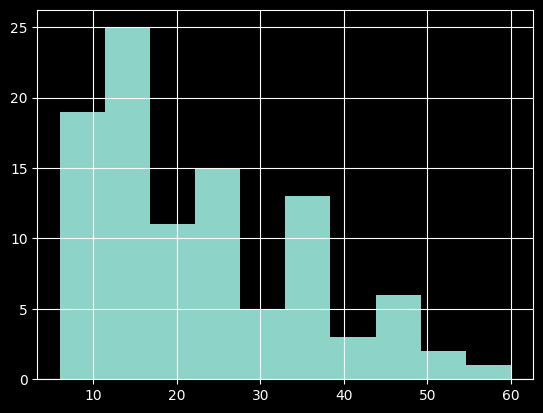

In [4]:
df_num['Duration'].hist()

<AxesSubplot: >

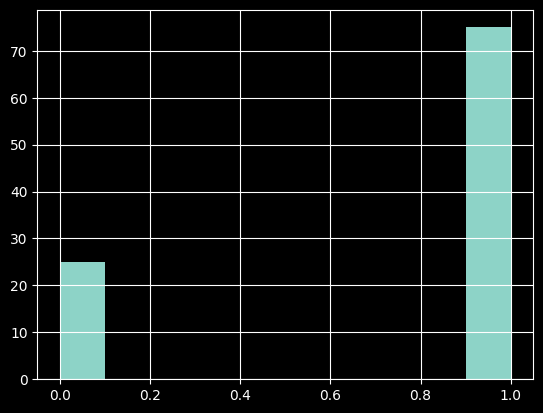

In [5]:
target.hist()

unbalanced labels -> use fscore (or whole coufusion matrix)

In [6]:
from src.utils import DataCollection
data = DataCollection(df_bool.values, df_num.values, target.values, batch_size=64)

# Binarization strategy

### Manual

In [8]:
# too boring, wont do that

### Statistical

In [9]:
from sklearn.preprocessing import KBinsDiscretizer

In [10]:
class SklearnBinarizer(nn.Module):
    def __init__(self, sklearn_discretizer):
        super().__init__()
        self.sklearn_discretizer = sklearn_discretizer
        
    def forward(self, x):
        x = self.sklearn_discretizer.transform(x)
        return torch.tensor(x.toarray(), dtype=torch.long)

In [11]:
discr = KBinsDiscretizer(strategy='quantile')
discr.fit(data.x_num['train'])
binarizer = SklearnBinarizer(discr)

### Neural

In [12]:
class NeuralBinarizer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    
    def forward(self, x):
        x = self.lin(x)
        return (torch.sigmoid(x)>0.5).to(torch.long)

In [13]:
binarizer = NeuralBinarizer(3, 15)

# Model

provided code did not work as intended, so i had to rewrite it almost entirely. new sourse code for ConceptNetwork is available in src/model.py

it was also refactored into a normal pytorch module, thus made more flaxible.

In [7]:
from src.model import ConceptNetwork

In [8]:
import fcapy
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx

K_train = FormalContext(data.x_bool['train'].astype(bool), target=data.y['train'].astype(bool))
L_train = ConceptLattice.from_context(K_train, algo='Sofia', L_max=15, is_monotone=True)

In [9]:
cn = ConceptNetwork(L_train, nonlinearity=nn.ReLU)

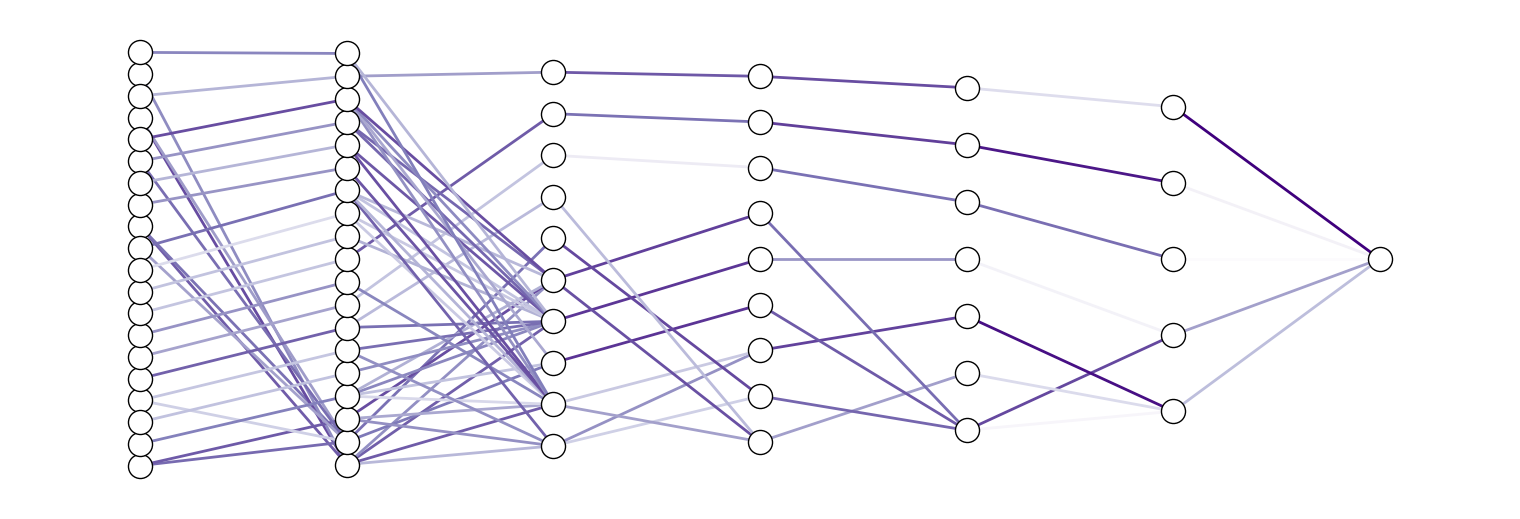

In [10]:
plt.figure(figsize=(15,5))
g, pos, weights = cn.networkx_graph()
pos_ = {node: (-y, x) for node, (x,y) in pos.items()}
nx.draw(
    g, pos_, edge_color=[weights[frozenset((u,v))] for u,v in g.edges], 
    edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

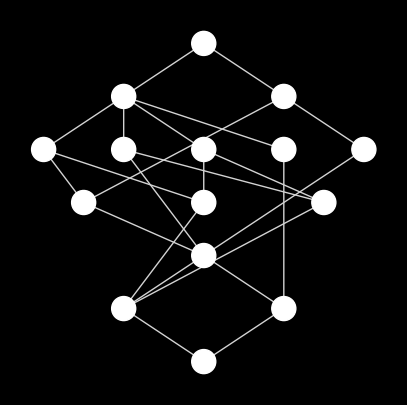

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
vis = LineVizNx(node_border_color='g', node_color='w')
vis.draw_poset(L_train, ax=ax);

## Training

In [12]:
x = data.train_ds.tensors[0].to(torch.float)
y = data.train_ds.tensors[2].to(torch.float)[:,None]
optimizer = torch.optim.Adam(cn.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for t in tqdm(range(2000)):
    optimizer.zero_grad()
    y_pred = cn(x)
    loss = loss_fn(y_pred, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

0.5623351335525513


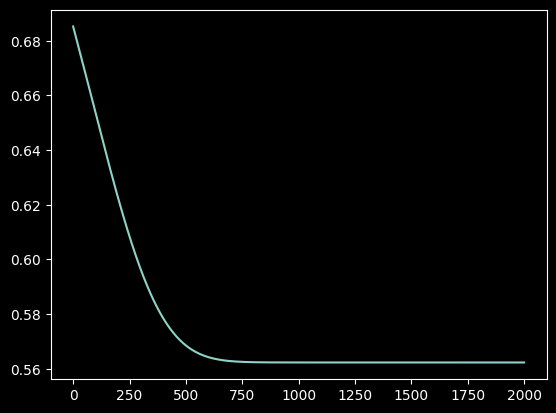

In [13]:
plt.plot(losses)
print(losses[-1])

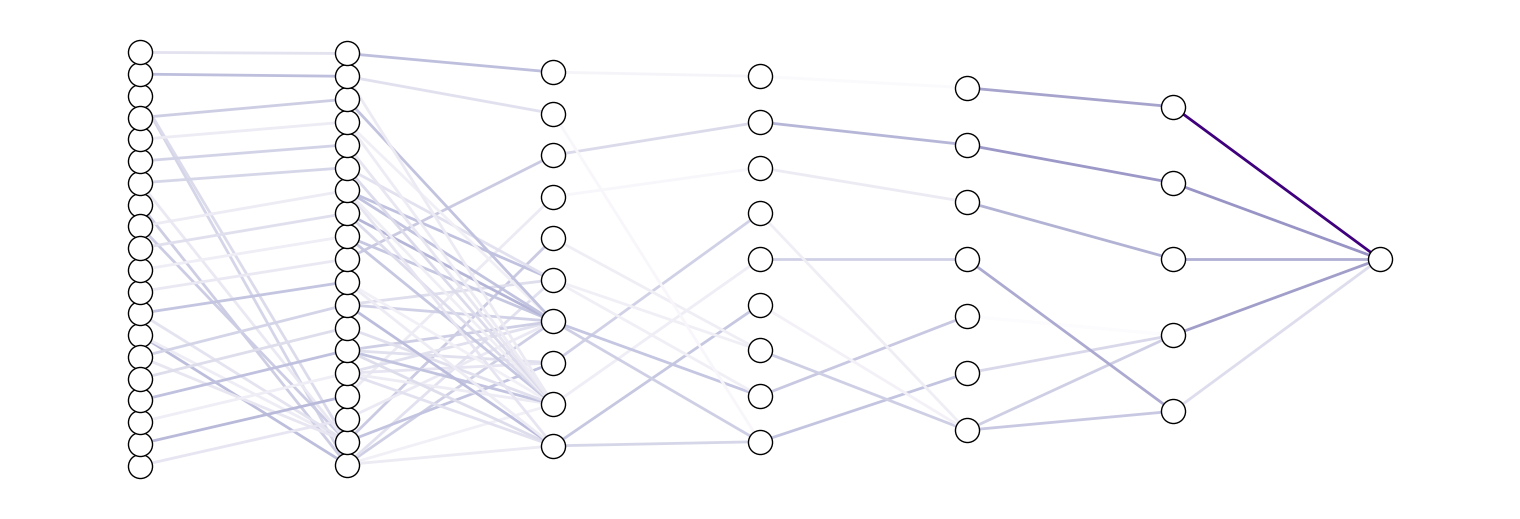

In [14]:
plt.figure(figsize=(15,5))
g, pos, weights = cn.networkx_graph()
pos_ = {node: (-y, x) for node, (x,y) in pos.items()}
nx.draw(
    g, pos_, edge_color=[weights[frozenset((u,v))] for u,v in g.edges], 
    edge_cmap=plt.cm.Purples, node_color='w', edgecolors='black', width=2)

# Experiments

# Other model comparison

knn, random forests, boosting, mlp, tabnet

couldnt make abything to work with a reasonable amount of effort, due to this field being so underdeveloped